# 2nd_ML100days_Notes_EDA

## 範例資料集描述 (Demo Dataset Description)
<img src="img/Kaggle_Home Credit Default Risk.png" width="800">  
* **Competition Description**  
    Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

    Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

    While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.  
    
    
* **Evaluation**  
    Submissions are evaluated on area under the **ROC curve** between the predicted probability and the observed target.

## 載入套件 (Import libs.)

In [1]:
# Import libs
import warnings
import os
import copy
import pandas as pd
import scipy as sp
import numpy as np

# Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libs
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

# Other setups
warnings.simplefilter('ignore')
%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# File path
dir_data = './data/'
dir_img = './img/'

## 前處理 (Preprocessing)

In [2]:
# 設定訓練資料集以及測試資料集檔案路徑
f_app_train = os.path.join(dir_data, 'application_train.csv')
f_app_test = os.path.join(dir_data, 'application_test.csv')

# 讀取訓練資料集以及測試資料集
app_train = pd.read_csv(f_app_train)
app_test = pd.read_csv(f_app_test)

# 檢查訓練資料集以及測試資料集內容
print(f"Shape of training dataset: {app_train.shape}")
display(app_train.head(3))
print(f"Shape of training dataset: {app_test.shape}")
display(app_test.tail(3))

# 保留預測標的數量為了之後方便進行索引
train_num = app_train.shape[0]

# 為了方便作特徵工程，先將訓練資料集以及測試資料集沿縱軸合併 (axis default: 0)
app_df = pd.concat([app_train, app_test]).reset_index(drop=True)
print(f"Shape of app_df: {app_df.shape}")

# 為了提升範例的閱讀性，對 DAYS_BIRTH 和 DAYS_EMPLOYED 作些簡單的特徵工程
app_df['AGE'] = abs(app_df['DAYS_BIRTH']) / 365
app_df.drop(['DAYS_BIRTH'], axis=1, inplace=True)

app_df['YEARS_EMPLOYED'] = abs(app_df['DAYS_EMPLOYED']) / 365
app_df.drop(['DAYS_EMPLOYED'], axis=1, inplace=True)

Shape of training dataset: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Shape of training dataset: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
48743,456250,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


Shape of app_df: (356255, 122)


In [3]:
# 找出資料集裡所有欄位的資料格式與對應的數量
dtype_df = app_df.dtypes.reset_index()
dtype_df.columns = ['Type_counts', 'Column Type']
dtype_df = dtype_df.groupby('Column Type').aggregate('count').reset_index()
display(dtype_df)

# 確定只有 int64, float64, object 三種類型後，依資料格式將欄名稱分組於三個列表中
int_features = []
float_features = []
object_features = []

for dtype, feature in zip(app_df.dtypes, app_df.columns):
    if dtype == 'float64':
        float_features.append(feature)
    elif dtype == 'int64':
        int_features.append(feature)
    else:
        object_features.append(feature)

print(f"{len(int_features)} Integer Features : {int_features}\n")
print(f"{len(float_features)} Float Features : {float_features}\n")
print(f"{len(object_features)} Object Features : {object_features}")

,Column Type,Type_counts
0,int64,38
1,float64,68
2,object,16


38 Integer Features : ['CNT_CHILDREN', 'DAYS_ID_PUBLISH', 'FLAG_CONT_MOBILE', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_EMAIL', 'FLAG_EMP_PHONE', 'FLAG_MOBIL', 'FLAG_PHONE', 'FLAG_WORK_PHONE', 'HOUR_APPR_PROCESS_START', 'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'SK_ID_CURR']

68 Float Features : ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_RE

In [4]:
# 做完特徵工程後，將訓練資料集以及測試資料集拆開
app_train = app_df.iloc[:train_num]
app_test = app_df.iloc[train_num::]
print(f"Shape of training dataset: {app_train.shape}")
print(f"Shape of training dataset: {app_test.shape}")

Shape of training dataset: (307511, 122)
Shape of training dataset: (48744, 122)


## 探索式數據分析 (Exploratory Data Analysis, EDA)
探索式數據分析（EDA）是一種分析數據集以總結其主要特徵的方法，其主要概念是透過敘述性統計、統計繪圖、視覺化等快速簡易的方式，從各種面向先了解資料的狀況，以利後續分析。


### Supplementary 
1. [What is Exploratory Data Analysis?](https://reurl.cc/Zz6zg)
2. [如何达到Kaggle竞赛top 2%？这里有一篇特征探索经验帖](https://reurl.cc/gpdYp)

<img src="img/探索式數據分析_相關係數.png" width="800">  
### 相關係數
相關係數用於度量兩個變數$x$和$y$之間的相關程度(線性相依)，其值介於$-1$與$1$之間，負值代表負相關，正值代表正相關，數值的大小代表相關性的強度。  

**1. Pearson相關係數** [np.corrcoef(x, y)](https://reurl.cc/q3l30) / [df.corr()](https://reurl.cc/xkrkN)
   * 0.00 - 0.19: 非常低度相關
   * 0.20 - 0.39: 低度相關
   * 0.40 - 0.59: 中度相關
   * 0.60 - 0.79: 高度相關
   * 0.80 - 1.00: 非常高度相關
$$ r\:\:=\:\frac{1}{n-1}\sum_{i=1}^{n}(\frac{x_{i}-\overline{x}}{s_{x}})(\frac{y_{i}-\overline{y}}{s_{y}}) $$


**2. 相關係數視覺化** [sns.heatmap(df.corr())](https://reurl.cc/7WxaQ) 

#### **參考資料** 
   1. [如何通俗易懂地解释「协方差」与「相关系数」的概念？](https://reurl.cc/kQzQ9)

### - 計算相關係數 -

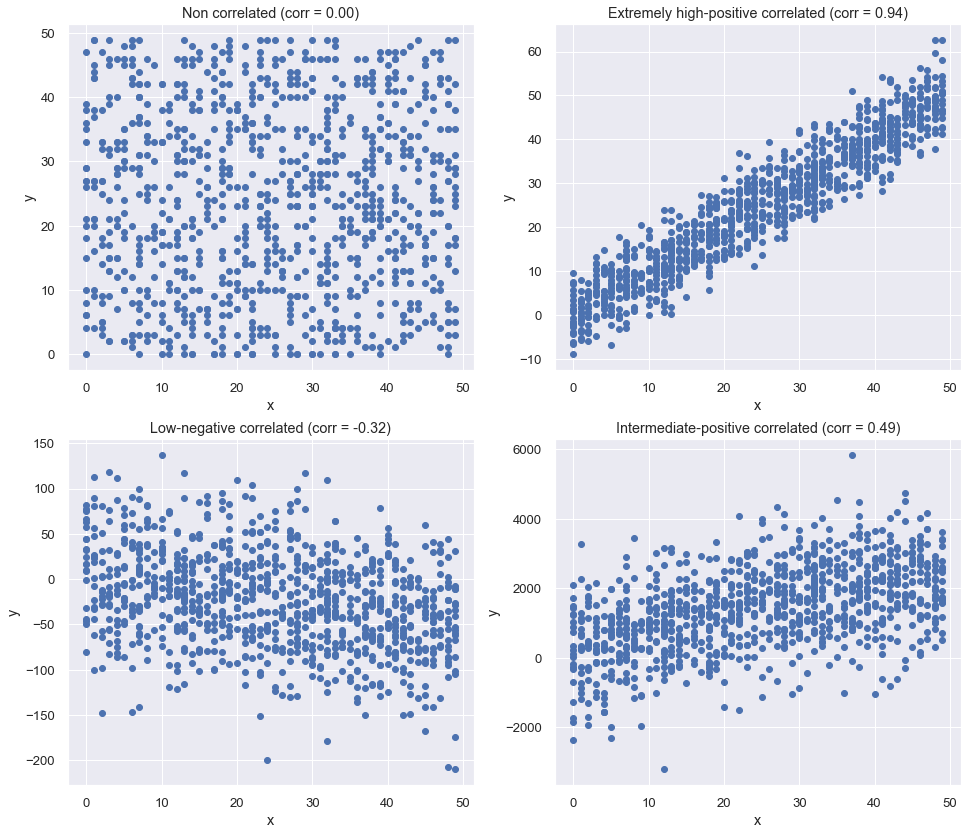

In [5]:
np.random.seed(1)
figure, ax = plt.subplots(2,2,figsize=(16,14))

# 無相關(弱相關)
plt.subplot(2,2,1)
x = np.random.randint(0, 50, 1000)
y = np.random.randint(0, 50, 1000)
plt.scatter(x, y); 
plt.xlabel('x'); plt.ylabel('y'); plt.title(f"Non correlated (corr = {np.corrcoef(x, y)[0][1]:.2f})");

# 非常高度正相關
plt.subplot(2,2,2)
y = x + np.random.normal(0, 5, 1000)
plt.scatter(x, y); 
plt.xlabel('x'); plt.ylabel('y'); plt.title(f"Extremely high-positive correlated (corr = {np.corrcoef(x, y)[0][1]:.2f})");

# 低度負相關
plt.subplot(2,2,3)
y = -x + np.random.normal(0, 50, 1000)
plt.scatter(x, y);  
plt.xlabel('x'); plt.ylabel('y'); plt.title(f"Low-negative correlated (corr = {np.corrcoef(x, y)[0][1]:.2f})");

# 中度正相關
plt.subplot(2,2,4)
y = 90*x - x**2 + np.random.normal(0, 1000, 1000)
plt.scatter(x, y); 
plt.xlabel('x'); plt.ylabel('y'); plt.title(f"Intermediate-positive correlated (corr = {np.corrcoef(x, y)[0][1]:.2f})");

### - 相關係數視覺化 -

,TARGET,AGE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
TARGET,1.000000,-0.078239,-0.155317,-0.160472,-0.178919
AGE,-0.078239,1.000000,0.600610,0.091996,0.205478
EXT_SOURCE_1,-0.155317,0.600610,1.000000,0.213982,0.186846
EXT_SOURCE_2,-0.160472,0.091996,0.213982,1.000000,0.109167
EXT_SOURCE_3,-0.178919,0.205478,0.186846,0.109167,1.000000


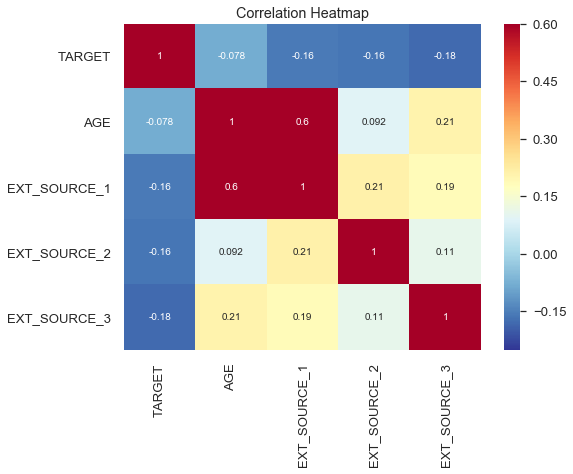

In [6]:
# 計算感興趣的欄位之間的相關係數
display(app_train[['TARGET', 'AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr())

# 繪製相關係數的 Heatmap
plt.figure(figsize =(8,6))
sns.heatmap(app_train[['TARGET', 'AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].corr(), 
            cmap=plt.cm.RdYlBu_r, vmin=-0.25, annot=True, vmax=0.6)
plt.title('Correlation Heatmap');

<img src="img/探索式數據分析_核密度函數.png" width="800">  
### 核密度函數
在統計學中，核密度估計（KDE）是一種估計隨機變量的概率密度函數的非參數方法。核密度估計是基礎數據平滑問題，其中基於有限數據樣本對群體進行推斷。

* **直方圖** [plt.hist(df)](https://reurl.cc/WV2Vk)
* **核密度圖** [sns.kdeplot(df)](https://reurl.cc/Gl3D3)
* **分佈圖** [sns.distplot(df)](https://reurl.cc/WV9nL)

#### **參考資料** 
   1. [核密度估计基础](https://reurl.cc/Vqde6)
   2. [核密度估计 Kernel Density Estimation(KDE)](https://reurl.cc/Ea9WA)
   3. [Python可视化：Seaborn库热力图使用进阶](https://reurl.cc/oqap3)
   4. [Visualizing Data with Pairs Plots in Python](https://reurl.cc/1p5Mp)

### 直方圖

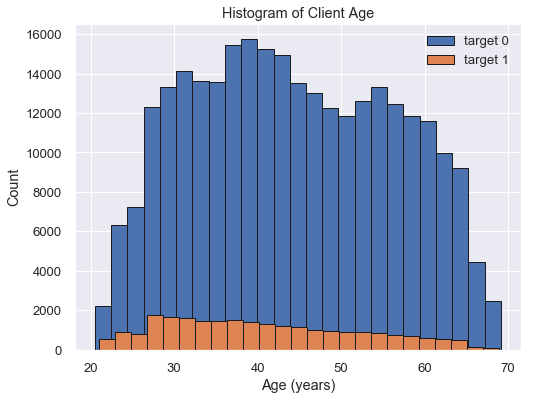

In [18]:
# 以年齡繪製直方圖
plt.figure(figsize =(8,6))
plt.hist(app_train.loc[app_train['TARGET']==0, 'AGE'], edgecolor='k', bins=25, label='target 0')  # TARGET 0 為準時還貸者
plt.hist(app_train.loc[app_train['TARGET']==1, 'AGE'], edgecolor='k', bins=25, label='target 1')  # TARGET 1 為非準時還貸者
plt.legend(); plt.xlabel('Age (years)'); plt.ylabel('Count'); plt.title('Histogram of Client Age'); 

### 核密度圖

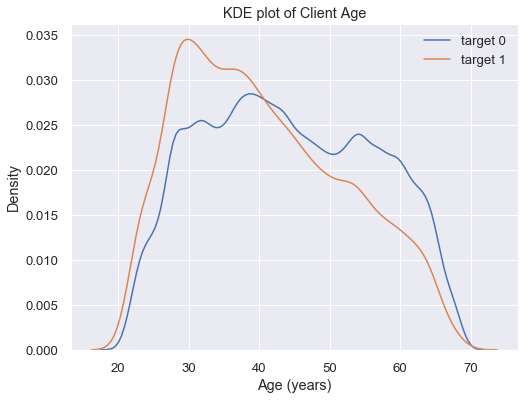

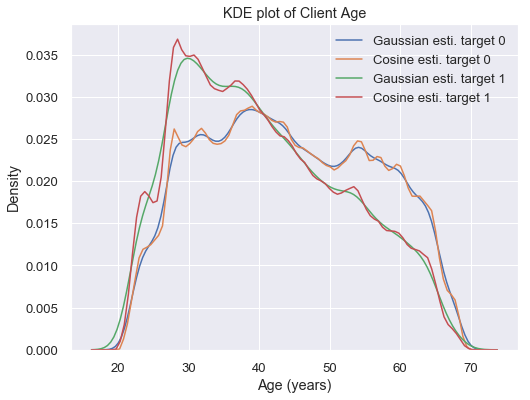

In [8]:
# 以年齡繪製 KDE 圖 (kernel default: gaussian)
plt.figure(figsize =(8,6))
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'AGE'], label='target 0')  # TARGET 0 為準時還貸者
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'AGE'], label='target 1')  # TARGET 1 為非準時還貸者
plt.legend(); plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('KDE plot of Client Age');

# 比較不同的 kernel function
plt.figure(figsize =(8,6))  # 開新的畫布
for i in [0, 1]:
    sns.kdeplot(app_train.loc[app_train['TARGET']==i, 'AGE'], label='Gaussian esti. target '+str(i), kernel='gau')
    sns.kdeplot(app_train.loc[app_train['TARGET']==i, 'AGE'], label='Cosine esti. target '+str(i), kernel='cos')
plt.legend(loc='upper right'); plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('KDE plot of Client Age');

### 分佈圖

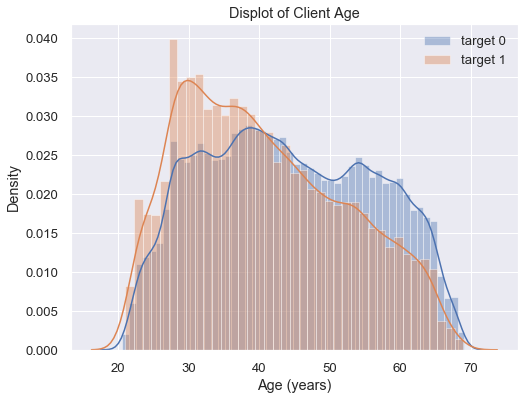

In [9]:
# 以年齡繪製 displot(bar 與 KDE 同時呈現)
plt.figure(figsize =(8,6))
sns.distplot(app_train.loc[app_train['TARGET']==0, 'AGE'], label='target 0')
sns.distplot(app_train.loc[app_train['TARGET']==1, 'AGE'], label='target 1')
plt.legend(); plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Displot of Client Age');

<img src="img/探索式數據分析_離散化.png" width="800">  
### 離散化
數值離散化在數據挖掘和發現知識方面扮演者重要的角色。許多研究表明歸納任務能從離散化中獲益：有離散值的規則通常是更簡短，更容易理解，並且離散化能改善預測精度。[1]  

**1. 離散化的優勢** [2]
   * 離散特徵的增加和減少都很容易，易於模型的快速迭代。
   * 稀疏向量內積乘法運算速度快，計算結果方便存儲，容易擴展。
   * 離散化後的特徵對異常值具有很好的強健性，比如一個特徵是年齡$>30$是$1$，否則$0$。如果特徵沒有離散化，一個異常數據 "年齡300歲" 會給模型造成很大的干擾。
   * 邏輯回歸屬於廣義線性模型，表達能力受限；單變量離散化為$N$個後，每個變量有單獨的權重，相當於為模型引入了非線性，能夠提升模型表達能力，增強擬合力。
   * 離散化後可以進行特徵交叉，由$M+N$個變量變為$MxN$個變量，進一步引入非線性，提升表達能力。
   * 特徵離散化後，模型會更穩定，比如如果對用戶年齡離散化，$20-30$ 作為一個區間，不會因為一個用戶年齡長了一歲就變成一個完全不同的人。當然處於區間相鄰處的樣本會剛好相反，所以怎麼劃分區間是門學問。
   * 特徵離散化以後，起到了簡化了邏輯回歸模型的作用，降低了模型過擬合的風險。
   
李沐曾經說過：模型是使用離散特徵還是連續特徵，其實是一個 **海量離散特徵+簡單模型** 同 **少量連續特徵+複雜模型** 的權衡。既可以離散化用線性模型，也可以用連續特徵加深度學習。就看是喜歡折騰特徵還是折騰模型了。通常來說，前者容易，而且可以多個人一起並行做，有成功經驗；後者目前看很贊，能走多遠還須拭目以待。

**2. 離散化方法** [3]  
* **無監督方法**  
ㅤ
    + **主觀切分** [pd.cut(df)](https://reurl.cc/NEekm)  
        主要是根據經驗和美觀，加上個人對數據的了解人為劃分。  
ㅤ
    + **等寬切分** [pd.cut(df)](https://reurl.cc/NEekm)  
       根據使用者指定的區間數目$K$，將屬性的值域$[x_{min}\:,\:x_{max}\:]$劃分成$K$個區間，並使每個區間的寬度相等。缺點是容易受離群點的影響而使效能不佳。  
ㅤ
    + **等頻切分** [pd.qcut(df)](https://reurl.cc/WV957)  
       等頻演算法也是根據使用者自定義的區間數目，將屬性的值域劃分成$K$個小區間。他要求落在每個區間的物件數目相等。譬如，屬性的取值區間內共有$M$個點，則等頻區間所劃分的$K$個小區域內，每個區域含有$\frac{M}{K}$個點。  
ㅤ
    + **K-means 聚類切分**  
       首先由使用者指定離散化產生的區間數目$K$，演算法首先從資料集中隨機找出$M$個數據作為$K$個初始區間的重心；然後，根據這些重心的歐式距離，對所有的物件聚類：如果資料$x$ 距重心$G_{i}$最近，則將$x$ 劃歸$G_{i}$所代表的那個區間；然後重新計算各區間的重心，並利用新的重心重新聚類所有樣本。逐步迴圈，直到所有區間的重心不再隨演算法迴圈而改變為止。  
  
  
- **監督方法**  
ㅤ
    + **基於卡方的離散方法**  
       首先將數值特徵的每個不同值看做一個區間對每對相鄰區間計算卡方統計量，如果大於閾值就合併，遞歸進行直到找不到卡方統計大於閾值的時候停止。  
ㅤ
    + **基於熵的離散方法**  
       其實就是照搬了決策樹的思路，使用合成的方法或者分裂的方法根據熵計算和閾值判定來決定合成或分裂。

#### **參考資料** 
   1. [特征离散化系列(一)方法综述](https://reurl.cc/NEekx)
   2. [连续特征的离散化：在什么情况下将连续的特征离散化之后可以获得更好的效果？](https://reurl.cc/eZYeL)
   3. [连续特征离散化的方法](https://reurl.cc/VqVrn)
   

### - 無監督方法 -
### 主觀切分 / 等寬切分 / 等頻切分

In [15]:
# 主觀切分，使用者決定 bin 的值
app_train['CUSTOM_AGE_GRP'] = pd.cut(app_train['AGE'], bins=np.linspace(20, 70, num=11))
print('主觀切分')
display(app_train['CUSTOM_AGE_GRP'].value_counts().sort_index())

# 等寬切分，每個 bin 的值的範圍大小都是一樣的
app_train['EQUAL_WIDTH_AGE_GRP'] = pd.cut(app_train['AGE'], 10)
print('等寬切分')
display(app_train['EQUAL_WIDTH_AGE_GRP'].value_counts().sort_index())

# 等頻切分，每個 bin 的資料筆數是相近的 (資料通常無法完美等分)
app_train['EQUAL_FREQ_AGE_GRP'] = pd.qcut(app_train['AGE'], 10, duplicates='drop')
print('等頻切分')
display(app_train['EQUAL_FREQ_AGE_GRP'].value_counts().sort_index())

# 觀察數據變成怎樣
display(app_train[['AGE', 'CUSTOM_AGE_GRP', 'EQUAL_WIDTH_AGE_GRP', 'EQUAL_FREQ_AGE_GRP']].head())

主觀切分


(20.0, 25.0]    12159
(25.0, 30.0]    32862
(30.0, 35.0]    39440
(35.0, 40.0]    42868
(40.0, 45.0]    41406
(45.0, 50.0]    35135
(50.0, 55.0]    34942
(55.0, 60.0]    33120
(60.0, 65.0]    27476
(65.0, 70.0]     8103
Name: CUSTOM_AGE_GRP, dtype: int64

等寬切分


(20.469, 25.378]    13679
(25.378, 30.238]    33127
(30.238, 35.099]    38430
(35.099, 39.959]    41758
(39.959, 44.819]    40350
(44.819, 49.679]    34311
(49.679, 54.54]     33544
(54.54, 59.4]       32650
(59.4, 64.26]       27685
(64.26, 69.121]     11977
Name: EQUAL_WIDTH_AGE_GRP, dtype: int64

等頻切分


(20.517, 28.175]    30752
(28.175, 32.038]    30760
(32.038, 36.0]      30745
(36.0, 39.496]      30759
(39.496, 43.151]    30745
(43.151, 47.178]    30764
(47.178, 51.74]     30733
(51.74, 56.093]     30758
(56.093, 60.77]     30757
(60.77, 69.121]     30738
Name: EQUAL_FREQ_AGE_GRP, dtype: int64

,AGE,CUSTOM_AGE_GRP,EQUAL_WIDTH_AGE_GRP,EQUAL_FREQ_AGE_GRP
0,25.920548,"(25.0, 30.0]","(25.378, 30.238]","(20.517, 28.175]"
1,45.931507,"(45.0, 50.0]","(44.819, 49.679]","(43.151, 47.178]"
2,52.180822,"(50.0, 55.0]","(49.679, 54.54]","(51.74, 56.093]"
3,52.068493,"(50.0, 55.0]","(49.679, 54.54]","(51.74, 56.093]"
4,54.608219,"(50.0, 55.0]","(54.54, 59.4]","(51.74, 56.093]"


<img src="img/探索式數據分析_繪圖.png" width="800">  
### 繪圖
為了清晰有效地傳遞資訊，資料視覺化使用統計圖形、圖表、資訊圖表和其他工具。可以使用點、線或條對數字資料進行編碼，以便在視覺上傳達定量資訊。有效的視覺化可以幫助用戶分析和推理資料和證據。它使複雜的資料更容易理解、理解和使用。

最常見的結構化數據類型包括連續的數字數據和離散的分類數據，因此，基本上會以易於人類理解的圖去描繪一個或多個數據屬性，如散點圖，直方圖，箱形圖等。

**1. 繪圖排版**  
   * **子圖** [plt.subplot(nrows, ncols, idx)](https://reurl.cc/4G902)  
  
  
**2. 常用圖形**  
   * **分佈**
        + **分佈圖** [sns.distplot(df)](https://reurl.cc/WV9nL)
        + **盒鬚圖** [sns.boxplot(xcol, ycol, df)](https://reurl.cc/eZYrL)
        + **提琴圖** [sns.violinplot(xcol, ycol, df)](https://reurl.cc/9Q8lx)
   * **關聯**
        + **散佈圖** [sns.regplot(xcol, ycol, df)](https://reurl.cc/a7y3D)
        + **熱圖** [sns.heatmap(df.corr())](https://reurl.cc/7WxaQ)
        + **對子圖** [sns.PairGrid(df)](https://reurl.cc/dvZY6)
   * **排序**
        + **長條圖** [plt.bar(xcol, ycol)](https://reurl.cc/6ezoV)
   * **演變**
        + **折線圖** [plt.plot(xcol, ycol)](https://reurl.cc/LZGy7)  
        
#### **參考資料** 
   1. [The Python Graph Gallery](https://reurl.cc/q3e7p)
   2. [From Data to Viz](https://reurl.cc/z7937)
   3. [Seaborn(sns)官方文档学习笔记](https://reurl.cc/mN18A)
   4. [The Art of Effective Visualization of Multi-dimensional Data](https://reurl.cc/rnWyy)
   5. [Top 50 matplotlib Visualizations – The Master Plots](https://reurl.cc/6ez1V)

In [34]:
# 把 NAs 刪去，並抽樣 N_sample 筆資料
N_sample = 1000
app_train_sample = app_train.dropna().sample(n=N_sample, random_state=0)  
app_train_sample.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,...,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,AGE,YEARS_EMPLOYED,CUSTOM_AGE_GRP,EQUAL_WIDTH_AGE_GRP,EQUAL_FREQ_AGE_GRP
151089,25537.5,545040.0,450000.0,135000.0,0.0,0.0,1.0,1.0,0.0,3.0,...,0.9791,0.9791,0.7144,0.7182,0.7256,44.632877,0.589041,"(40.0, 45.0]","(39.959, 44.819]","(43.151, 47.178]"
112038,20538.0,337761.0,256500.0,315000.0,0.0,0.0,3.0,0.0,0.0,1.0,...,0.9692,0.9692,0.5784,0.5840,0.5949,34.728767,2.983562,"(30.0, 35.0]","(30.238, 35.099]","(32.038, 36.0]"
5051,61803.0,1494436.5,1395000.0,315000.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.9831,0.9831,0.7688,0.7719,0.7779,46.273973,7.564384,"(45.0, 50.0]","(44.819, 49.679]","(43.151, 47.178]"
225515,29250.0,585000.0,585000.0,202500.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.9975,0.9975,0.9592,0.9597,0.9608,40.043836,8.668493,"(40.0, 45.0]","(39.959, 44.819]","(39.496, 43.151]"
269004,14625.0,292500.0,292500.0,225000.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.9871,0.9871,0.8232,0.8256,0.8301,40.873973,1.983562,"(40.0, 45.0]","(39.959, 44.819]","(39.496, 43.151]"


###  - 繪圖排版 -
### 子圖

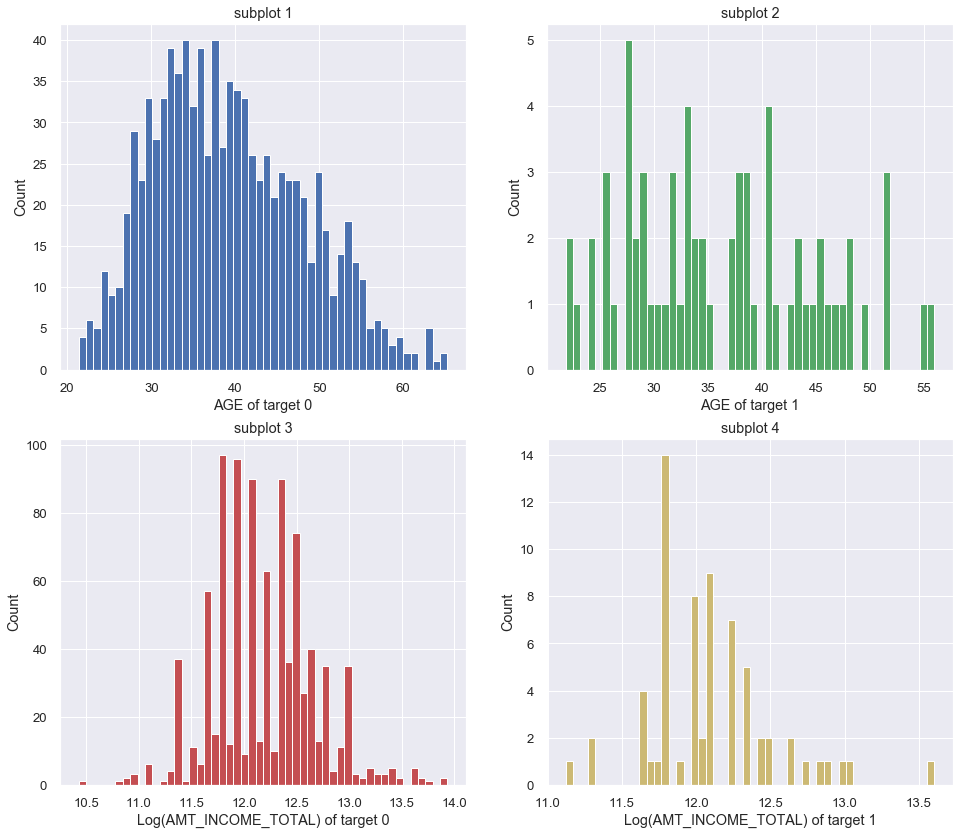

In [35]:
# 整彰畫布大小為 16x12 共有 2x2 張圖
nrows, ncols = 2, 2
figure, ax = plt.subplots(nrows, ncols, figsize=(16,14))

# plt.subplot(row, column, idx)
plt.subplot(2, 2, 1)
app_train_sample.loc[app_train_sample['TARGET']==0, 'AGE'].hist(bins=50)
plt.xlabel('AGE of target 0'); plt.ylabel('Count'); plt.title('subplot 1'); 

plt.subplot(2, 2, 2)
app_train_sample.loc[app_train_sample['TARGET']==1, 'AGE'].hist(bins=50, color='g')
plt.xlabel('AGE of target 1'); plt.ylabel('Count'); plt.title('subplot 2'); 

plt.subplot(2, 2, 3)
np.log(app_train_sample.loc[app_train_sample['TARGET']==0, 'AMT_INCOME_TOTAL']).hist(bins=50, color='r')
plt.xlabel('Log(AMT_INCOME_TOTAL) of target 0'); plt.ylabel('Count'); plt.title('subplot 3'); 

plt.subplot(2, 2, 4)
np.log(app_train_sample.loc[app_train_sample['TARGET']==1, 'AMT_INCOME_TOTAL']).hist(bins=50, color='y')
plt.xlabel('Log(AMT_INCOME_TOTAL) of target 1'); plt.ylabel('Count'); plt.title('subplot 4'); 

In [36]:
custom_age_grp = np.sort(app_train_sample['CUSTOM_AGE_GRP'].unique())
custom_age_grp

array([Interval(20.0, 25.0, closed='right'),
       Interval(25.0, 30.0, closed='right'),
       Interval(30.0, 35.0, closed='right'),
       Interval(35.0, 40.0, closed='right'),
       Interval(40.0, 45.0, closed='right'),
       Interval(45.0, 50.0, closed='right'),
       Interval(50.0, 55.0, closed='right'),
       Interval(55.0, 60.0, closed='right'),
       Interval(60.0, 65.0, closed='right'),
       Interval(65.0, 70.0, closed='right')], dtype=object)

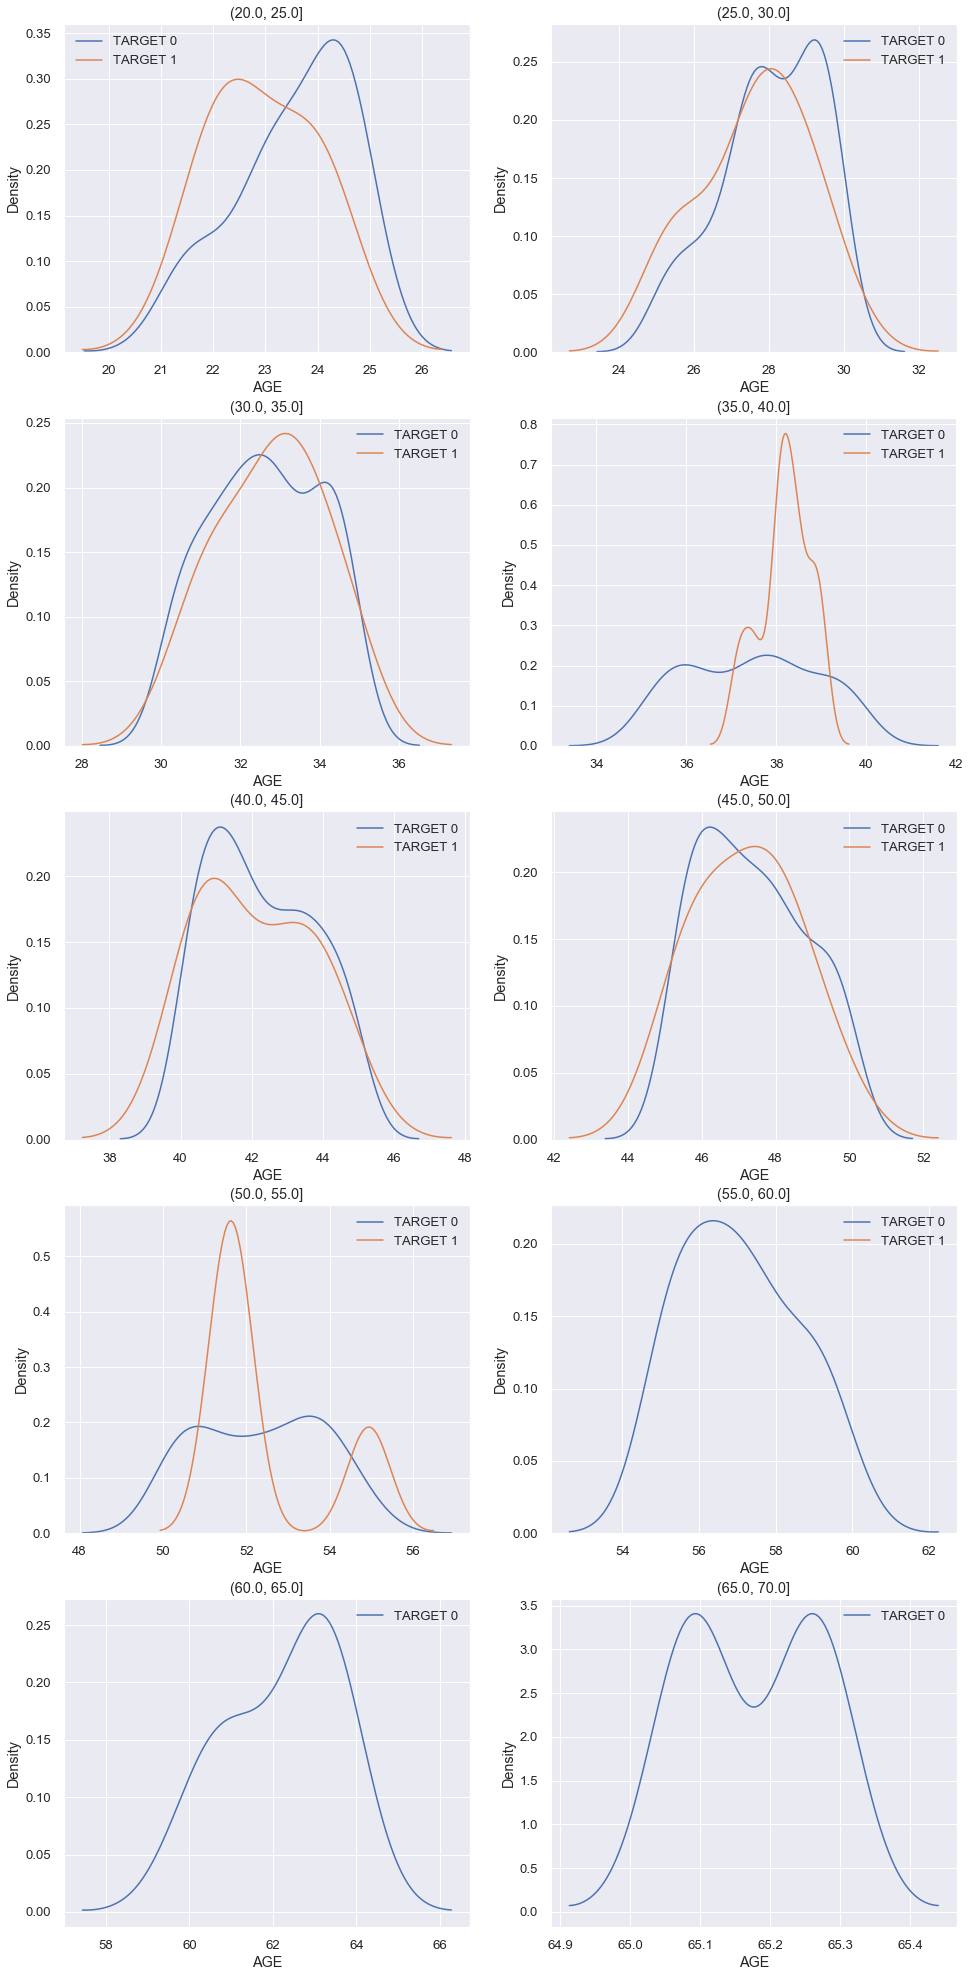

In [37]:
# 迴圈式 subplot
nrows, ncols = 5, 2
figure, ax = plt.subplots(nrows, ncols, figsize=(16,35))

for i in range(len(custom_age_grp)):
    plt.subplot(nrows, ncols, i+1)
    sns.distplot(app_train_sample.loc[(app_train_sample['CUSTOM_AGE_GRP'] == custom_age_grp[i]) & (app_train_sample['TARGET'] == 0), 'AGE'], 
                 label='TARGET 0', hist=False)
    sns.distplot(app_train_sample.loc[(app_train_sample['CUSTOM_AGE_GRP'] == custom_age_grp[i]) & (app_train_sample['TARGET'] == 1), 'AGE'], 
                 label='TARGET 1', hist=False)
    plt.ylabel('Density'); plt.title(str(custom_age_grp[i]))

### - 常用圖形 -
### 直方圖

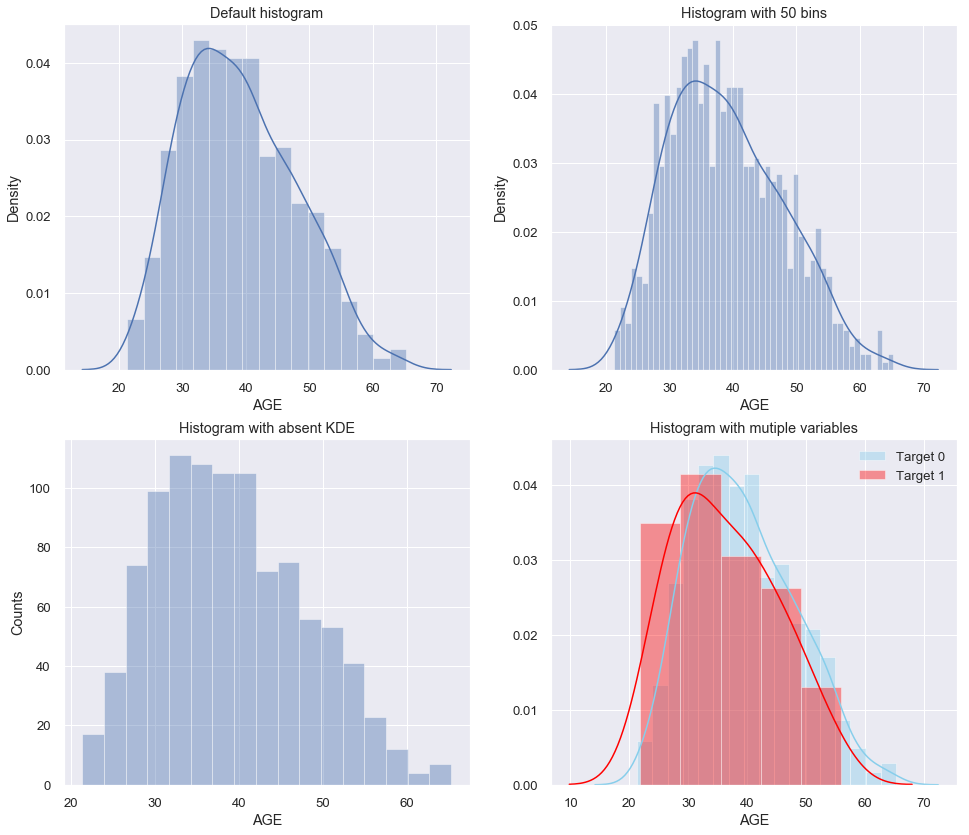

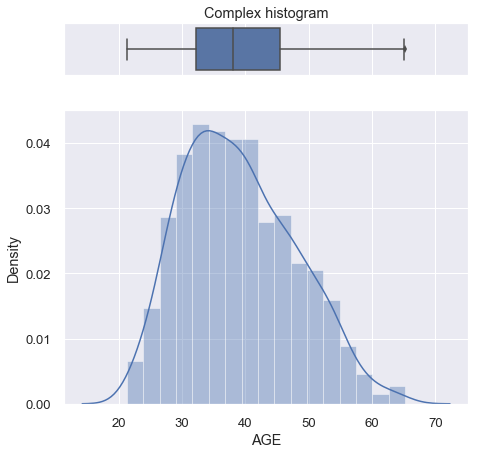

In [44]:
nrows = ncols = 2
figure, ax = plt.subplots(nrows, ncols, figsize=(16,14))

# Make default histogram of sepal length
plt.subplot(2, 2, 1)
sns.distplot(app_train_sample['AGE'])
plt.ylabel('Density'); plt.title('Default histogram');
 
# Control the number of bins
plt.subplot(2, 2, 2)
sns.distplot(app_train_sample['AGE'], bins=50)
plt.ylabel('Density'); plt.title('Histogram with 50 bins');

# Hist only
plt.subplot(2, 2, 3)
sns.distplot(app_train_sample['AGE'], hist=True, kde=False, rug=False)
plt.ylabel('Counts'); plt.title('Histogram with absent KDE');

# Histogram with several variables
plt.subplot(2, 2, 4)
sns.distplot(app_train_sample.loc[app_train_sample['TARGET']==0, 'AGE'], color='skyblue', label='Target 0')
sns.distplot(app_train_sample.loc[app_train_sample['TARGET']==1, 'AGE'], color='red', label='Target 1')
plt.xlabel('AGE'); plt.title('Histogram with mutiple variables'); plt.legend();

# Cut the window in 2 parts and add a graph in each part
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.15, .85)}, figsize=(7.25,7))
sns.boxplot(app_train_sample['AGE'], ax=ax_box)
sns.distplot(app_train_sample['AGE'], ax=ax_hist)
ax_hist.set(ylabel='Density'); ax_box.set(xlabel=''); ax_box.set(title='Complex histogram');

### 盒鬚圖

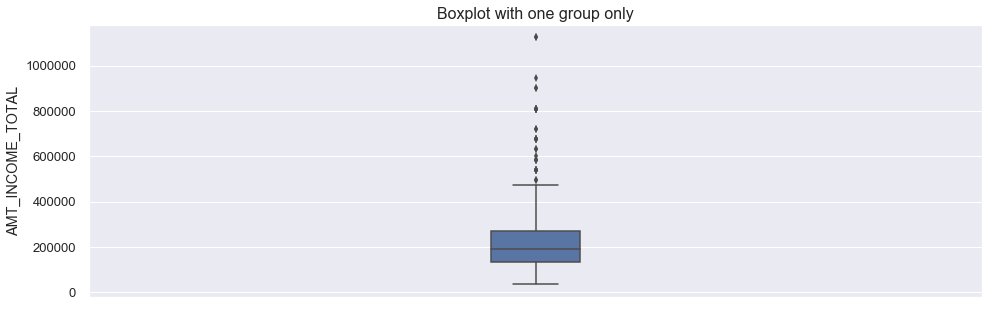

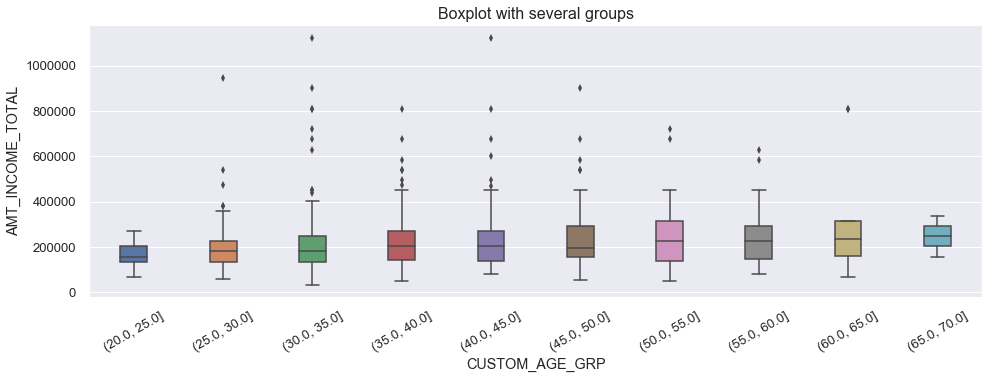

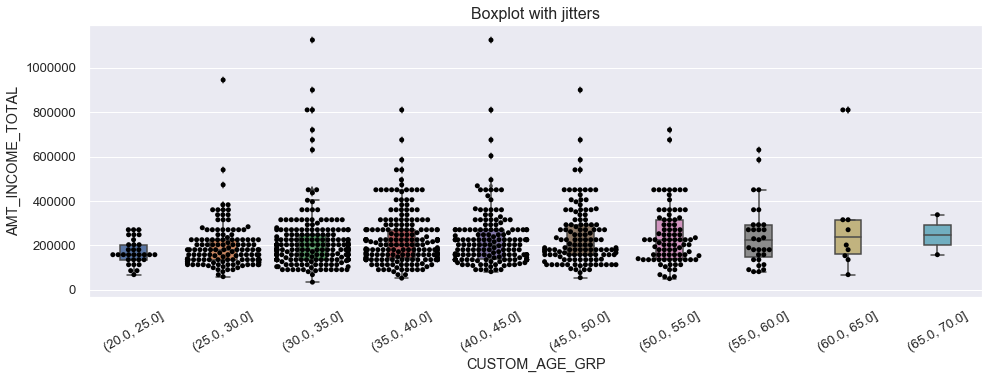

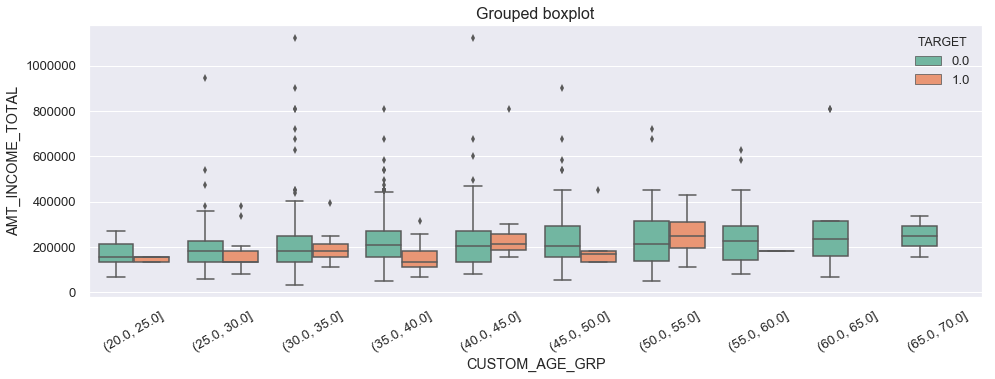

In [42]:
# Make boxplot for one group only
plt.figure(figsize=(16,5))
ax = sns.boxplot(y='AMT_INCOME_TOTAL', data=app_train_sample, width=0.1)
plt.title('Boxplot with one group only', fontsize=16);

# One numerical variable, and several groups
plt.figure(figsize=(16,5))
ax = sns.boxplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', data=app_train_sample, width=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.title('Boxplot with several groups', fontsize=16);

# Add jitter with the swarmplot function
plt.figure(figsize=(16,5))
ax = sns.boxplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', data=app_train_sample, width=0.3)
sns.swarmplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', data=app_train_sample, color='black')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.title('Boxplot with jitters', fontsize=16);

# Grouped boxplot
plt.figure(figsize=(16,5))
ax = sns.boxplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', hue='TARGET', data=app_train_sample, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.title('Grouped boxplot', fontsize=16);

### 提琴圖

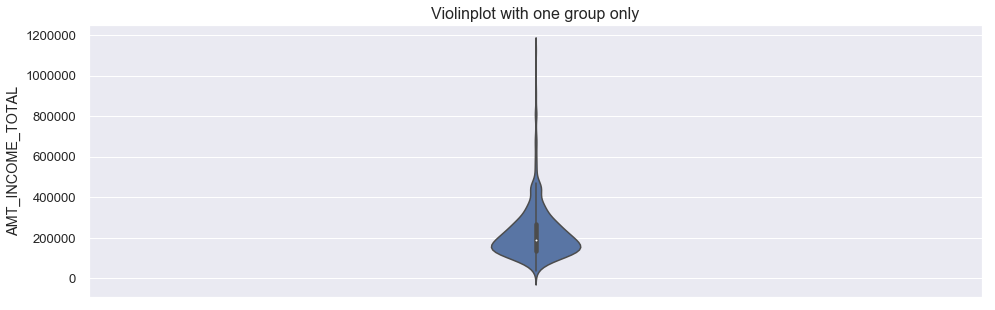

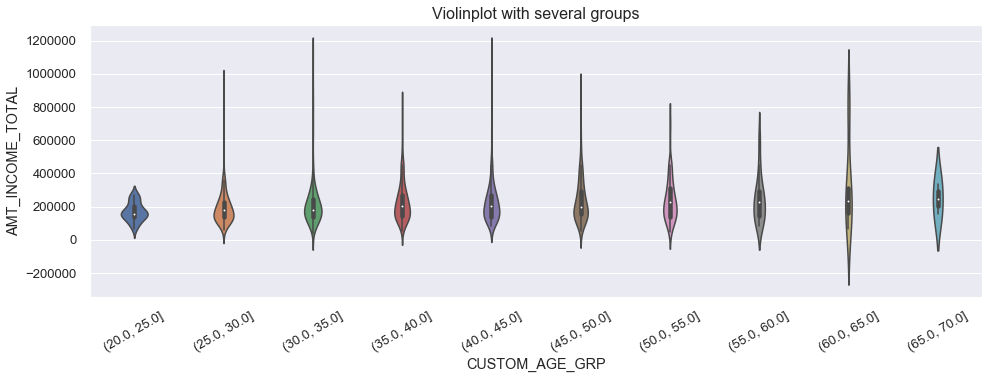

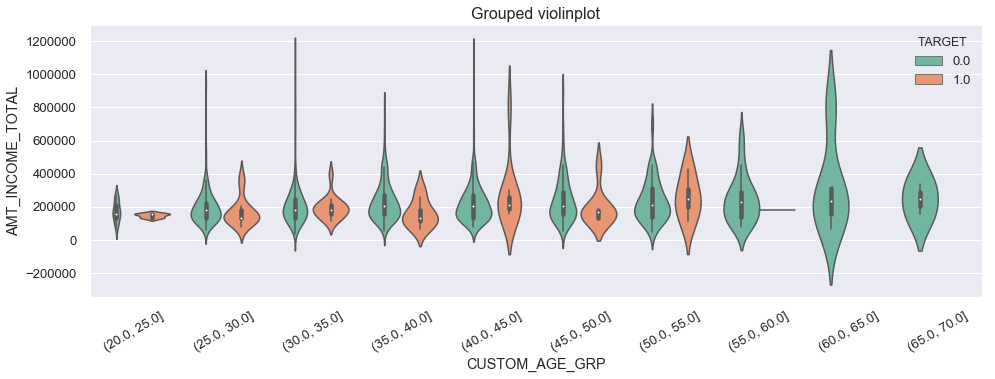

In [43]:
# Make violin plot for one group only
plt.figure(figsize=(16,5))
ax = sns.violinplot(y='AMT_INCOME_TOTAL', data=app_train_sample, width=0.1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
plt.title('Violinplot with one group only', fontsize=16);

# One numerical variable, and several groups
plt.figure(figsize=(16,5))
ax = sns.violinplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', data=app_train_sample, width=0.3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
plt.title('Violinplot with several groups', fontsize=16);

# Grouped violinplot
plt.figure(figsize=(16,5))
ax = sns.violinplot(x='CUSTOM_AGE_GRP', y='AMT_INCOME_TOTAL', hue='TARGET', 
                    data=app_train_sample, palette="Set2")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30);
plt.title('Grouped violinplot', fontsize=16);

### 散佈圖

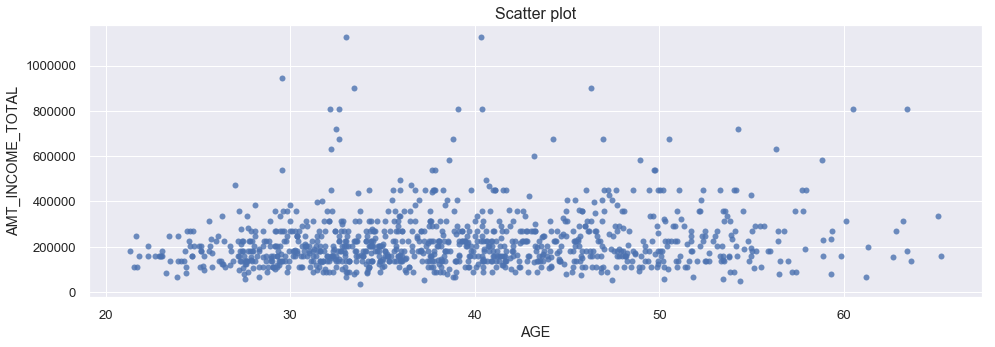

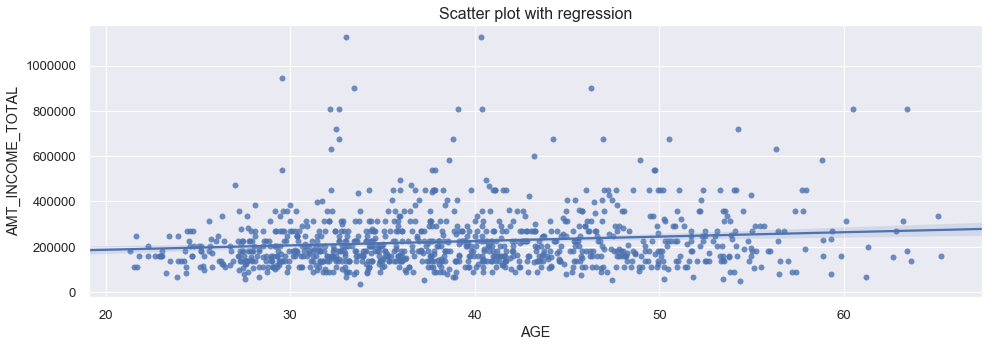

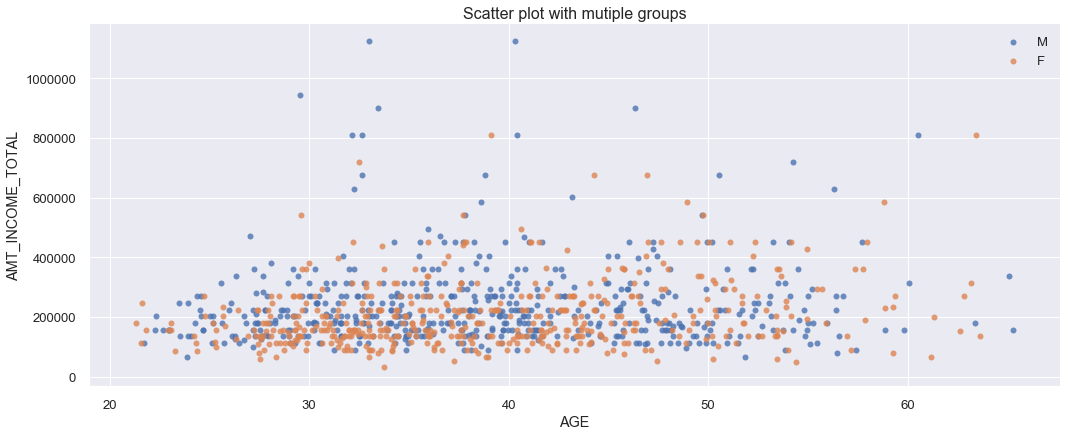

In [45]:
# Use the function regplot to make a scatterplot
plt.figure(figsize=(16,5))
sns.regplot(x='AGE', y='AMT_INCOME_TOTAL', data=app_train_sample, fit_reg=False);
plt.title('Scatter plot', fontsize=16);

# With regression fit:
plt.figure(figsize=(16,5))
sns.regplot(x='AGE', y='AMT_INCOME_TOTAL', data=app_train_sample);
plt.title('Scatter plot with regression', fontsize=16);

# Use the 'hue' argument to provide a factor variable
sns.lmplot(x='AGE', y='AMT_INCOME_TOTAL', data=app_train_sample, 
           fit_reg=False, hue='CODE_GENDER', height=6, aspect=2.5, legend=False);
plt.legend(loc='upper right'); plt.title('Scatter plot with mutiple groups', fontsize=16);

### 熱圖

,CNT_CHILDREN,DAYS_ID_PUBLISH,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,...,HOUR_APPR_PROCESS_START,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR
CNT_CHILDREN,1.000000,-0.028019,-0.000794,-0.002756,-0.005318,0.000293,0.003945,-0.005459,0.003609,0.010662,...,-0.007292,0.069957,0.014835,0.025423,0.024781,0.020072,0.070650,-0.013319,0.008185,-0.001129
DAYS_ID_PUBLISH,-0.028019,1.000000,-0.000802,-0.001214,0.022875,-0.002193,0.003048,0.008710,0.000158,0.002782,...,0.031676,0.061094,0.033938,-0.005103,-0.007737,0.076326,0.099354,0.034757,0.048071,-0.000384
FLAG_CONT_MOBILE,-0.000794,-0.000802,1.000000,0.000206,0.002710,0.000110,-0.064800,-0.072839,-0.013667,-0.030625,...,-0.001559,0.003742,-0.002923,0.013041,0.013651,-0.000878,0.003270,0.001044,-0.001324,0.002815
FLAG_DOCUMENT_10,-0.002756,-0.001214,0.000206,1.000000,-0.000299,-0.000012,-0.000284,-0.000259,-0.000166,-0.000478,...,-0.002597,0.001320,-0.000982,-0.000492,-0.001655,0.003689,0.000626,0.004989,0.002001,-0.000815
FLAG_DOCUMENT_11,-0.005318,0.022875,0.002710,-0.000299,1.000000,-0.000160,-0.003727,-0.003401,-0.002181,-0.006276,...,0.014224,0.002714,0.007409,-0.010348,-0.013152,0.055105,0.034236,0.103987,0.059071,-0.002012


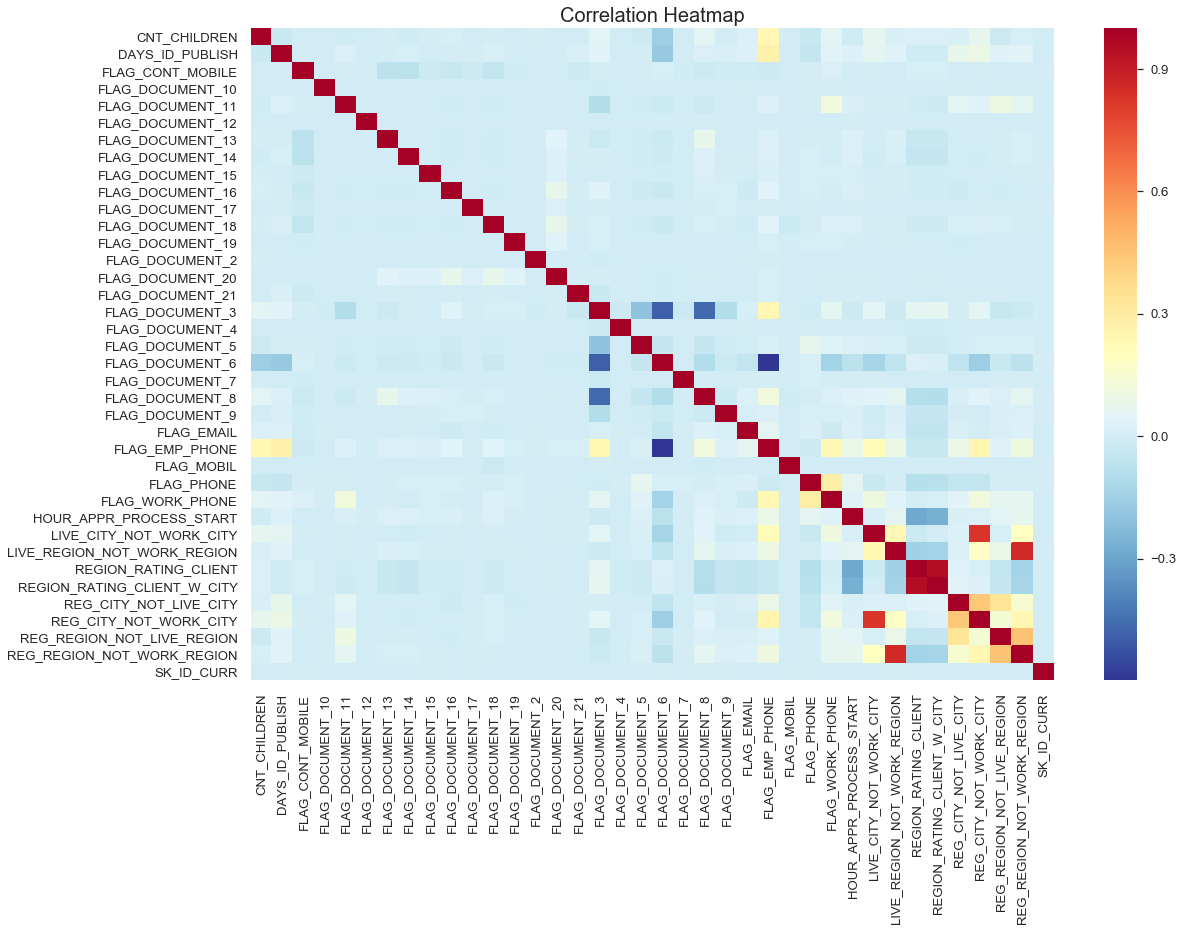

In [48]:
# 觀察資料型態為 int 的特徵之間的相關係數
display(app_train[int_features].corr().head())

plt.figure(figsize =(18,12))
sns.heatmap(app_train[int_features].corr(), cmap=plt.cm.RdYlBu_r, annot=False)
plt.title('Correlation Heatmap', fontsize=20);

### 對子圖

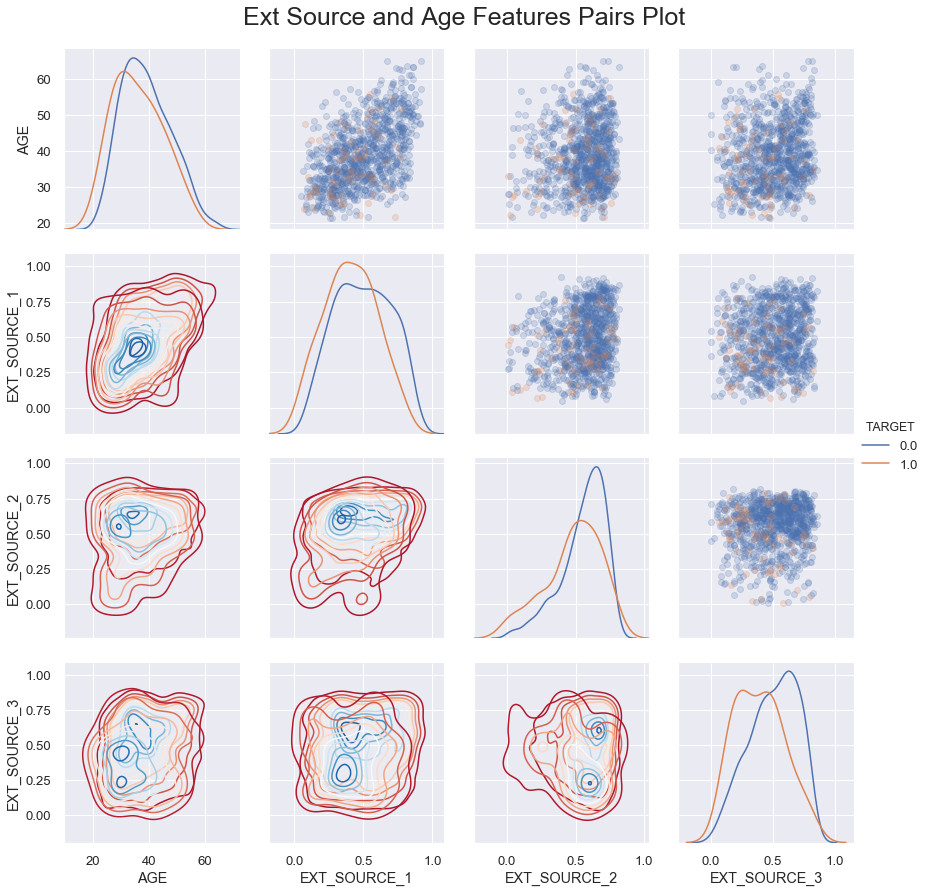

In [55]:
# 取出感興趣的欄位
app_train_ext_sample = app_train_sample[['TARGET', 'AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

# 建立 pairgrid 物件
p_grid = sns.PairGrid(data=app_train_ext_sample, size=3, diag_sharey=False, hue='TARGET', 
                      vars=[x for x in list(app_train_ext_sample.columns) if x != 'TARGET'])

# 上半部為 scatter
p_grid.map_upper(plt.scatter, alpha=0.2)

# 對角線畫 KDE plot(單變量)
p_grid.map_diag(sns.kdeplot)

# 下半部放 KDE plot(雙變量)
p_grid.map_lower(sns.kdeplot, cmap=plt.cm.RdBu)

plt.suptitle('Ext Source and Age Features Pairs Plot', size=25, y=1.03)
p_grid = p_grid.add_legend()

### 長條圖

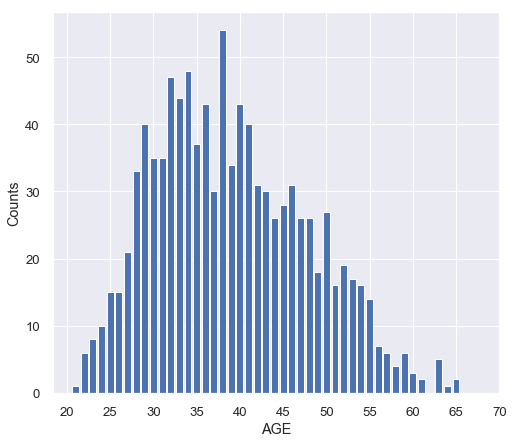

In [57]:
age_counts = round(app_train_sample['AGE']).value_counts().tolist()
age = round(app_train_sample['AGE']).value_counts().keys().tolist()

plt.figure(figsize =(8,7))
plt.bar(age, age_counts)
plt.xticks(range(20,71,5)); plt.xlabel('AGE'); plt.ylabel('Counts');

### 折線圖

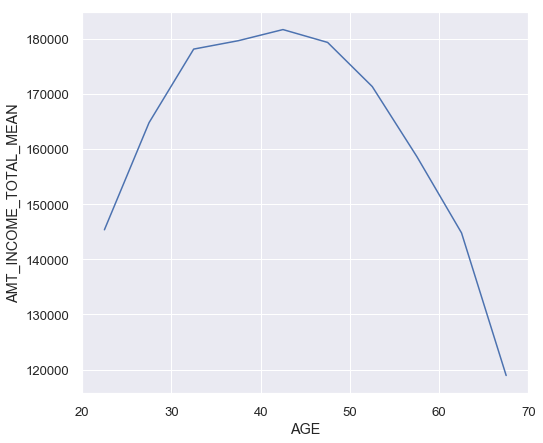

In [91]:
plt.figure(figsize =(8,7))
plt.plot(np.arange(22.5,70,5), app_train.groupby('CUSTOM_AGE_GRP')['AMT_INCOME_TOTAL'].mean().values)
plt.xlim(20,70); plt.xlabel('AGE'); plt.ylabel('AMT_INCOME_TOTAL_MEAN');

<img src="img/探索式數據分析_套用模型演算法.png" width="800">  
### 套用模型演算法

  
#### **參考資料** 
   1. [SK Learn官網](https://scikit-learn.org/stable/)

In [92]:
# 此處單純示範模型擬合的步驟，因此我們不做任何前處理或是特徵工程

# 選擇數值型資料為特徵
num_features = int_features + float_features

# 索引出送進模型訓練的資料集，因為模型不能用 NA 當作輸入資料，此處隨意地以 -1 做為補植的方法
train_X = app_df[num_features].iloc[:train_num].drop('TARGET', axis=1).fillna(-1)
train_Y = app_df['TARGET'].iloc[:train_num]

test_X = app_df[num_features].iloc[train_num+1::].drop('TARGET', axis=1).fillna(-1)

In [95]:
# Initialize
log_reg = LogisticRegression(C=0.001)

# Train
log_reg.fit(train_X, train_Y)

# Validation
print(f"CV score: {cross_val_score(log_reg, train_X, train_Y, cv=5).mean()}")

# Predict
log_reg_pred = log_reg.predict_proba(test_X)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV score: 0.9192386615364256
